In [1]:
from intermittentLevy.functions import *
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.optimize import dual_annealing
from scipy.stats import linregress
import scipy.optimize
from scipy.optimize import curve_fit

# Get the current notebook's directory
#notebook_dir = os.getcwd()
# Append the path to 'intermittentLevy' directory
#sys.path.append(os.path.join(notebook_dir, 'intermittentLevy'))
#import importlib
#import functions
#importlib.reload(functions)
# Import functions from 'functions.py'
#from functions import moment4, to_optimize_mom4, mom22_4_diff, to_optimize_mom22_4_diff, intermittent2, levy_flight_2D_2, setup_kde,mom2_model, mom4_model, form_groups, adjusted_r_square, load_parameters, setup_kde,powerl_fit, perform_iterations,perform_estimation


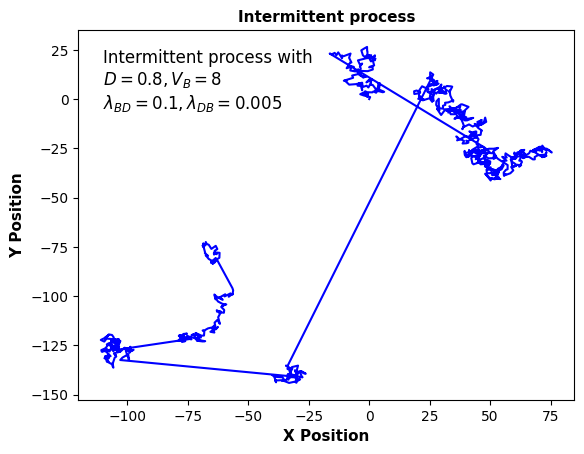

In [2]:
# Generate an intermittent trajectory
x, y = intermittent2(nt=1000, dt=1, mean_bal_sac=8, diffusion=0.8, rate21=0.1, rate12=0.005)
plt.plot(x, y, color='blue')
plt.xlabel('X Position',fontsize=11, fontweight='bold')
plt.ylabel('Y Position',fontsize=11, fontweight='bold')
plt.title('Intermittent process',fontsize=11, fontweight='bold')
param_text = "Intermittent process with\n$D = 0.8, V_B = 8$\n$\\lambda_{BD} = 0.1, \\lambda_{DB} = 0.005$"
plt.text(0.05, 0.95, param_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
#plt.savefig("Intermittent.pdf")
plt.show()

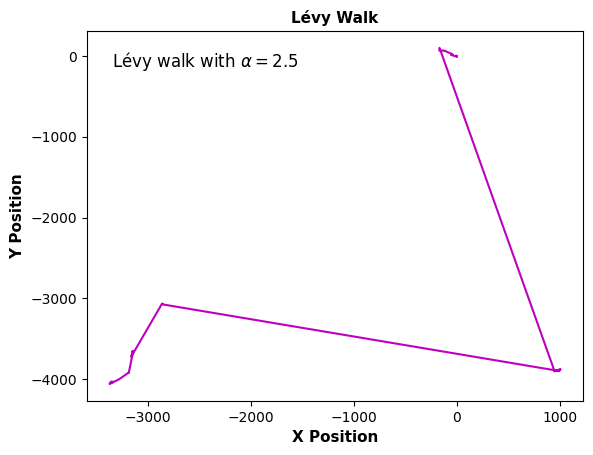

In [3]:
# Generate Lévy flight trajectory
x_measured, y_measured, _ = levy_flight_2D_2(n_redirections=10000, n_max=10000, lalpha=1.5, tmin=1, measuring_dt=1)
plt.plot(x_measured, y_measured, color='m')
plt.xlabel('X Position',fontsize=11, fontweight='bold')
plt.ylabel('Y Position',fontsize=11,fontweight='bold')
plt.title('Lévy Walk',fontsize=11,fontweight='bold')
param_text = r"Lévy walk with $\alpha = 2.5$"
plt.text(0.05, 0.95, param_text, transform=plt.gca().transAxes, fontsize=12,verticalalignment='top')
#plt.savefig("LeavyWalk.pdf")
plt.show()

In [4]:
# Load parameters, set up KDE, and define other simulation parameters
normed_loc_params, mean_params, std_params = load_parameters('intermittent_est_params.txt')
kde = setup_kde(normed_loc_params)

N = 1000000  # Number of points
N_iter = 1  # Number of iterations
integration_factor = 80
g_tau = 1
tau_list = np.arange(1, 50)
re_estimations = 5  
opt_iter = 200      
redim_max = 2
# Perform iterations
og_params, lev_params_int, adj_r_square_int_lev, adj_r_square_int_int, est_params, est_params2 = perform_iterations(
    N_iter, N, integration_factor, g_tau, kde, std_params, mean_params, tau_list
)

In [5]:
# Define the parameters for synthetic data
g_v0 = 5.0
g_D = 1.0
g_lambda_B = 0.05
lambda_B = 0.05
g_lambda_D = 0.005
factor1 = 1
factor2 = 1
factor3 = 1
factor4 = 1
# Compute synthetic data
tau_list = np.arange(1, 50)
x_loc,y_loc = intermittent2(N*integration_factor,g_tau/integration_factor,g_v0*factor1,g_D*factor2,g_lambda_B*factor3,
                            g_lambda_D*factor4)
    
# Initialize the lists
x_list, y_list, dx_list, dy_list = [], [], [], []
dx4, dy4, dx2, dy2 = [], [], [], []

for i in tau_list:
    x_list.append(x_loc[::i * integration_factor])
    y_list.append(y_loc[::i * integration_factor])
    dx_list.append(np.diff(x_loc[::i * integration_factor]))
    dy_list.append(np.diff(y_loc[::i * integration_factor]))

    dx4.append(np.mean(np.array(dx_list[-1])**4))
    dy4.append(np.mean(np.array(dy_list[-1])**4))
    dx2.append(np.mean(np.array(dx_list[-1])**2))
    dy2.append(np.mean(np.array(dy_list[-1])**2))
# Convert to NumPy arrays and compute logarithms
dx4, dy4 = np.array(dx4), np.array(dy4)
dx4_log, dy4_log = np.log10(dx4), np.log10(dy4)
dx2, dy2 = np.array(dx2), np.array(dy2)
dx2_log, dy2_log = np.log10(dx2), np.log10(dy2)


In [6]:

# Initial guess for fitting parameters
initial_guess = [g_v0 * factor1, g_D * factor2, g_lambda_B * factor3, g_lambda_D * factor4]

# Perform fitting using dual annealing
result = dual_annealing(to_optimize_mom4, [(1e-6, 1e6)] * 4, x0=initial_guess)
popt_x = result.x
print("popt_x:", popt_x)
# Calculate the difference
difference = np.array(dx4) - 2 * np.array(dx2)

result_diff = dual_annealing(to_optimize_mom22_4_diff_log, [(1e-6, 1e3)] * 4, x0=initial_guess)
popt_x_diff = result_diff.x
x_intermittent, y_intermittent = intermittent2(nt=1000000, dt=1, mean_bal_sac=g_v0, diffusion=g_D, rate21=g_lambda_B, rate12=g_lambda_D)
x_levy, y_levy, _ = levy_flight_2D_2(n_redirections=1000000, n_max=1000000, lalpha=1.5, tmin=1, measuring_dt=1)
def calculate_moments(data, tau_list):
    dx2 = []
    dx4 = []
    for tau in tau_list:
        dx = np.diff(data[::tau])
        dx2.append(np.mean(dx**2))
        dx4.append(np.mean(dx**4))
    return np.array(dx2), np.array(dx4)
dx2_intermittent, dx4_intermittent = calculate_moments(x_intermittent, tau_list)
dx2_levy, dx4_levy = calculate_moments(x_levy, tau_list)

popt_x: [5.    1.    0.05  0.005]


In [7]:
# Simplify the bounds to very wide ranges
simple_bounds = (0, np.inf)
# Double-check initial guesses
initial_guess = [g_v0*factor1, g_D*factor2, g_lambda_B*factor3, g_lambda_D*factor4]
print("Initial Guesses:", initial_guess)

# If initial_guess is derived from popt_x, ensure popt_x is feasible
print("Previous Optimal Parameters (popt_x):", popt_x)
# Quick test of the model function with different parameter sets
test_params = [1, 1, 1, 1]  
try:
    test_output = mom22_4_diff(tau_list, *test_params)
    print("Model function output with test parameters:", test_output)
except Exception as e:
    print("Error in model function with test parameters:", e)
try:
    popt_x_diff, pcov_x = scipy.optimize.curve_fit(
        mom22_4_diff, 
        np.array(tau_list), 
        (np.array(dx4) - 2 * np.array(dx2)),
        p0=initial_guess, 
        bounds=simple_bounds,
        maxfev=5000000
    )
    print("Optimized Parameters:", popt_x_diff)
except ValueError as e:
    print("ValueError encountered:", e)
popt_x_diff, pcov_x = scipy.optimize.curve_fit(mom22_4_diff, np.array(tau_list), (np.array(dx4) - 2*np.array(dx2)),p0 = popt_x ,bounds=(0.0001, [np.inf, np.inf, np.inf,np.inf]),maxfev=500000)
popt_x_diff2, pcov_x = scipy.optimize.curve_fit(mom22_4_diff, np.array(tau_list), (np.array(dx4) - 2*np.array(dx2)),p0 = [g_v0*factor1,g_D*factor2,g_lambda_B*factor3,g_lambda_D*factor4] ,bounds=(0.0001, [np.inf, np.inf, np.inf,np.inf]),maxfev=500000)
popt_x_diff2
import numpy as np
from scipy.optimize import curve_fit

Initial Guesses: [5.0, 1.0, 0.05, 0.005]
Previous Optimal Parameters (popt_x): [5.    1.    0.05  0.005]
Model function output with test parameters: [2.73069091e+00 1.53484771e+01 3.98449608e+01 7.73550777e+01
 1.28275073e+02 1.92708059e+02 2.70667177e+02 3.62145296e+02
 4.67134410e+02 5.85629245e+02 7.17626875e+02 8.63125814e+02
 1.02212535e+03 1.19462515e+03 1.38062506e+03 1.58012503e+03
 1.79312501e+03 2.01962500e+03 2.25962500e+03 2.51312500e+03
 2.78012500e+03 3.06062500e+03 3.35462500e+03 3.66212500e+03
 3.98312500e+03 4.31762500e+03 4.66562500e+03 5.02712500e+03
 5.40212500e+03 5.79062500e+03 6.19262500e+03 6.60812500e+03
 7.03712500e+03 7.47962500e+03 7.93562500e+03 8.40512500e+03
 8.88812500e+03 9.38462500e+03 9.89462500e+03 1.04181250e+04
 1.09551250e+04 1.15056250e+04 1.20696250e+04 1.26471250e+04
 1.32381250e+04 1.38426250e+04 1.44606250e+04 1.50921250e+04
 1.57371250e+04]
Optimized Parameters: [8.22888382e+00 1.31078223e-01 5.17875708e-02 6.70950376e-04]


In [8]:
# Fit the second moment
popt_dx2_intermittent, _ = curve_fit(mom2_model, tau_list, dx2_intermittent)
popt_dx2_levy, _ = curve_fit(mom2_model, tau_list, dx2_levy)

# Fit the fourth moment
popt_dx4_intermittent, _ = curve_fit(mom4_model, tau_list, dx4_intermittent)
popt_dx4_levy, _ = curve_fit(mom4_model, tau_list, dx4_levy)


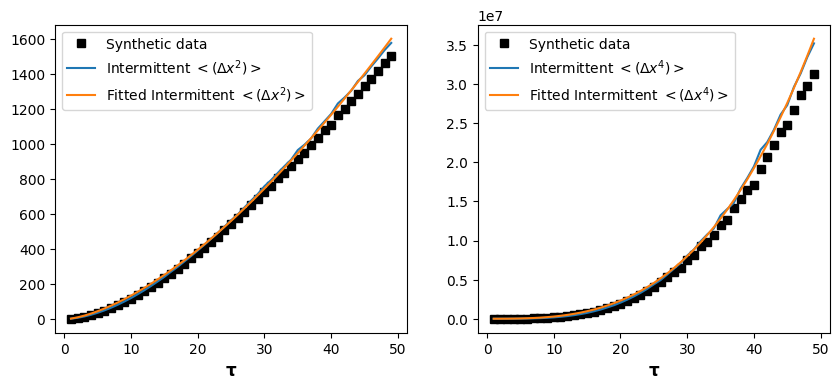

In [9]:
plt.figure(figsize=(10, 4))
# Plot for the second moment
plt.subplot(1, 2, 1)
plt.plot((tau_list), dx2, 'ks', alpha=1, label='Synthetic data')
plt.plot(tau_list, dx2_intermittent, label='Intermittent $<(Δx^2)>$')  # Corrected label
plt.plot(tau_list, mom2_model(tau_list, *popt_dx2_intermittent), label='Fitted Intermittent $<(Δx^2)>$')
#plt.plot(tau_list, dx2_levy, label='Lévy $<(Δx^2)>$')
#plt.plot(tau_list, mom2_model(tau_list, *popt_dx2_levy), label='Fitted Lévy $<(Δx^2)>$')
plt.xlabel(r'$\mathbf{\tau}$', fontsize=12)  
plt.legend()

# Plot for the fourth moment
plt.subplot(1, 2, 2)
# Plot the synthetic data
plt.plot((tau_list), dx4, 'ks', alpha=1, label='Synthetic data')
plt.plot(tau_list, dx4_intermittent, label='Intermittent $<(Δx^4)>$')
plt.plot(tau_list, mom4_model(tau_list, *popt_dx4_intermittent), label='Fitted Intermittent $<(Δx^4)>$')
#plt.plot(tau_list, dx4_levy, label='Lévy $<(Δx^4)>$')
#plt.plot(tau_list, mom4_model(tau_list, *popt_dx4_levy), label='Fitted Lévy $<(Δx^4)>$')
plt.xlabel(r'$\mathbf{\tau}$', fontsize=12) 
plt.legend()
plt.show()


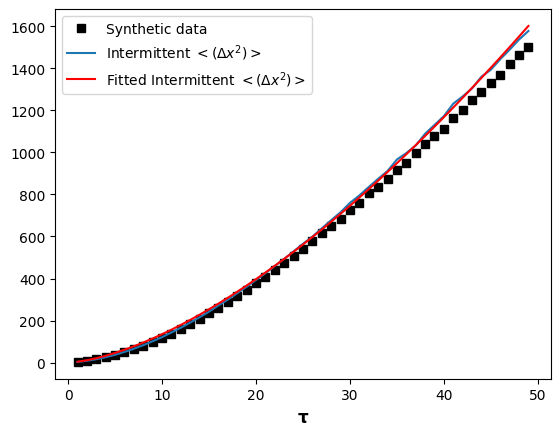

In [10]:
plt.plot((tau_list), dx2, 'ks', alpha=1, label='Synthetic data')
plt.plot(tau_list, dx2_intermittent, label='Intermittent $<(Δx^2)>$')
plt.plot(tau_list, mom2_model(tau_list, *popt_dx2_intermittent),color = "red", label='Fitted Intermittent $<(Δx^2)>$')
#plt.plot(tau_list, dx2_levy, label='Lévy $<(Δx^2)>$')
#plt.plot(tau_list, mom2_model(tau_list, *popt_dx2_levy), label='Fitted Lévy $<(Δx^2)>$')
plt.xlabel(r'$\mathbf{\tau}$', fontsize=12) 
plt.legend()
#plt.savefig("int_d_x2.pdf")
plt.show()


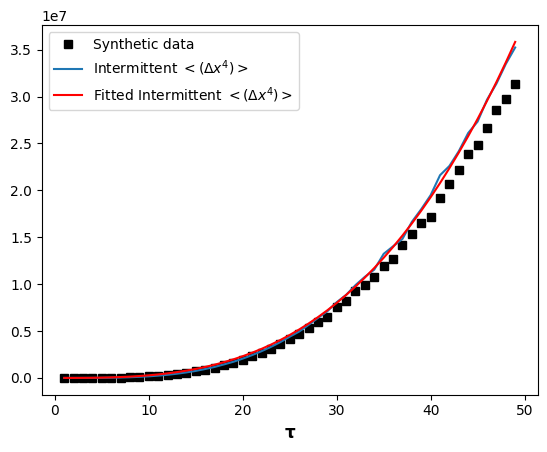

In [11]:
# Plot the synthetic data
plt.plot((tau_list), dx4, 'ks', alpha=1, label='Synthetic data')
plt.plot(tau_list, dx4_intermittent, label='Intermittent $<(Δx^4)>$')
plt.plot(tau_list, mom4_model(tau_list, *popt_dx4_intermittent),color = "red", label='Fitted Intermittent $<(Δx^4)>$')
#plt.plot(tau_list, dx4_levy, label='Lévy $<(Δx^4)>$')
#plt.plot(tau_list, mom4_model(tau_list, *popt_dx4_levy), label='Fitted Lévy $<(Δx^4)>$')
plt.xlabel(r'$\mathbf{\tau}$', fontsize=12) 
plt.legend()
#plt.savefig("int_d_x4.pdf")
plt.show()

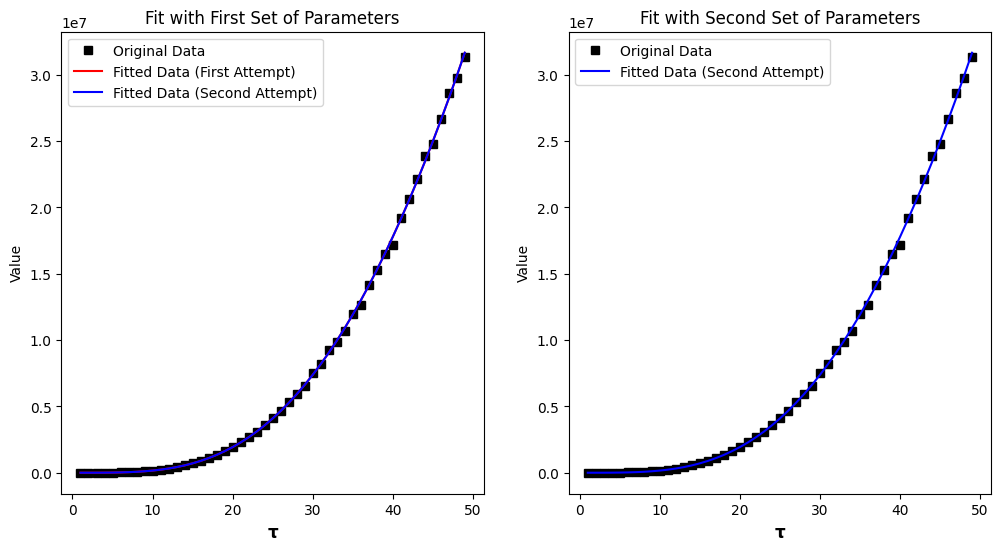

In [12]:
# Original Data
original_data = dx4

# Fitted Data Using First Set of Optimized Parameters
fitted_data1 = mom22_4_diff(np.array(tau_list), *popt_x_diff)

# Fitted Data Using Second Set of Optimized Parameters
fitted_data2 = mom22_4_diff(np.array(tau_list), *popt_x_diff2)

# Plotting
plt.figure(figsize=(12, 6))

# Plot with first set of parameters
plt.subplot(1, 2, 1)
plt.plot(tau_list, original_data, 'ks', label='Original Data')
plt.plot(tau_list, fitted_data1, label='Fitted Data (First Attempt)', color='red')
plt.plot(tau_list, fitted_data2, label='Fitted Data (Second Attempt)', color='blue')
plt.xlabel(r'$\mathbf{\tau}$', fontsize=12)
plt.ylabel('Value')
plt.title('Fit with First Set of Parameters')
plt.legend()

# Plot with second set of parameters
plt.subplot(1, 2, 2)
plt.plot(tau_list, original_data, 'ks', label='Original Data')
plt.plot(tau_list, fitted_data2, label='Fitted Data (Second Attempt)', color='blue')
plt.xlabel(r'$\mathbf{\tau}$', fontsize=12)
plt.ylabel('Value')
plt.title('Fit with Second Set of Parameters')
plt.legend()
plt.show()


## Levy

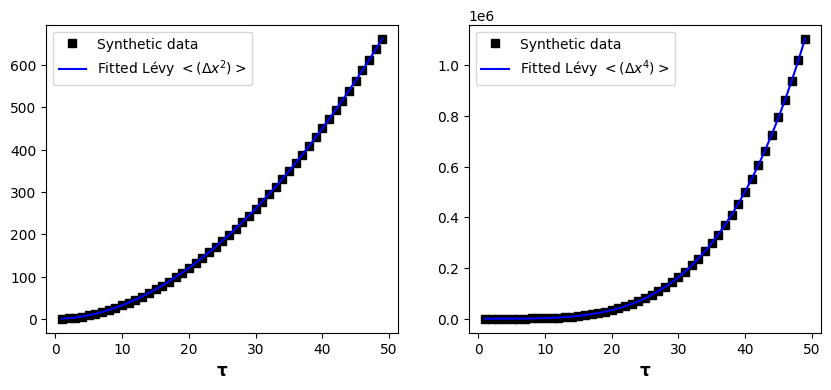

In [13]:
import numpy as np
o_t_mins = 0.007
l_alpha = 2
tau_list = np.arange(1, 50)
# Function to calculate moments
'''def calculate_moments(data, tau_list):
    dx2 = []
    dx4 = []
    for tau in tau_list:
        dx = np.diff(data[::tau])
        dx2.append(np.mean(dx**2))
        dx4.append(np.mean(dx**4))
    return np.array(dx2), np.array(dx4)'''

# Main loop for parameter sweep
for factor1 in np.arange(0, 1, 1.0 / 1):
    for factor2 in np.arange(0, 0.008, 1):
        g_t_mins = 1.5 * o_t_mins - 0.5 * factor1 * o_t_mins

        # Reset dy_lev and dx_lev for each parameter set
        dy_lev = []
        dx_lev = []

        for i in range(10):
            # Generate synthetic data
            lx_lev, ly_lev, lt_lev = levy_flight_2D_2(int(15000000 * l_alpha * 0.01 / g_t_mins), 150000, l_alpha, g_t_mins, 1)
            dy_lev.append(np.diff(ly_lev))
            dx_lev.append(np.diff(lx_lev))

        # Aggregate the data
        y_lev = np.cumsum(np.hstack(dy_lev))
        x_lev = np.cumsum(np.hstack(dx_lev))

        # Calculate momentsx
        dx2, dx4 = calculate_moments(x_lev,tau_list)

        # Fit the moments
        popt_dx2, _ = curve_fit(mom2_model, tau_list, dx2)
        popt_dx4, _ = curve_fit(mom4_model, tau_list, dx4)

        # Plotting
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)  # Plot for the second moment
        plt.plot(tau_list, dx2, 'ks', alpha=1, label='Synthetic data')
        plt.plot(tau_list, mom2_model(tau_list, *popt_dx2), label='Fitted Lévy $<(Δx^2)>$',color ='blue')
        plt.xlabel(r'$\mathbf{\tau}$', fontsize=12, fontweight = 'bold')
        plt.legend()
        #plt.savefig("bestlevy_fit_2.pdf")

        plt.subplot(1, 2, 2)  # Plot for the fourth moment
        plt.plot(tau_list, dx4, 'ks', alpha=1, label='Synthetic data')
        plt.plot(tau_list, mom4_model(tau_list, *popt_dx4), label='Fitted Lévy $<(Δx^4)>$',color ='blue')
        plt.xlabel(r'$\mathbf{\tau}$', fontsize=12,fontweight = 'bold')
        plt.legend()
        #plt.savefig("bestlevy_fit_4.pdf")
        plt.show()

In [14]:
#plt.plot(lx_lev, ly_lev)

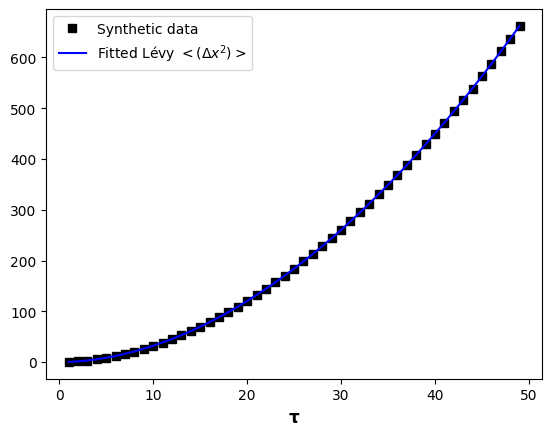

In [15]:
plt.plot(tau_list, dx2, 'ks', alpha=1, label='Synthetic data')
plt.plot(tau_list, mom2_model(tau_list, *popt_dx2), label='Fitted Lévy $<(Δx^2)>$',color ='blue')
plt.xlabel(r'$\mathbf{\tau}$', fontsize=12, fontweight = 'bold')
plt.legend()
#plt.savefig("bestlevy_fit_2.pdf")
plt.show()


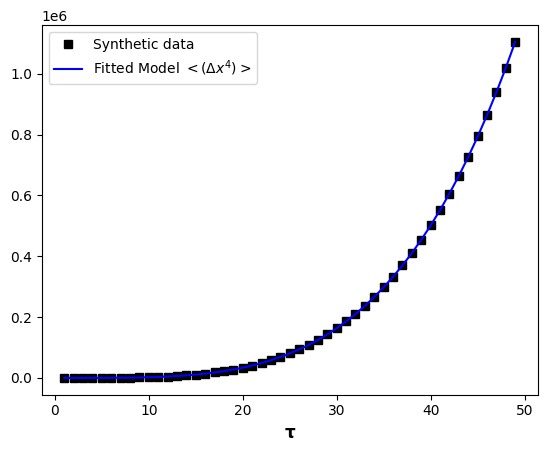

In [16]:
plt.plot(tau_list, dx4, 'ks', alpha=1, label='Synthetic data')
plt.plot(tau_list, mom4_model(tau_list, *popt_dx4), label='Fitted Model $<(Δx^4)>$',color ='blue')
plt.xlabel(r'$\mathbf{\tau}$', fontsize=12,fontweight = 'bold')
plt.legend()
#plt.savefig("bestlevy_fit_4.pdf")
plt.show()

# Intermittent and Lévy-walk

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from sklearn.neighbors import KernelDensity
import functools
import math
import seaborn as sns
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
import random

In [18]:
log_tau_list = np.arange(0,13,1)
tau_list = np.power(2,log_tau_list)
int_second_moment_list = []
int_fourth_moment_list = []
g_v0 = 4
g_D = 1
g_lambda_B = 0.01
g_lambda_D = 0.002
for i in range(len(tau_list)):
    int_second_moment_list.append(mom2(tau_list[i],g_v0,g_D, g_lambda_B, g_lambda_D))
    int_fourth_moment_list.append(moment4(tau_list[i],g_v0,g_D, g_lambda_B, g_lambda_D))


    

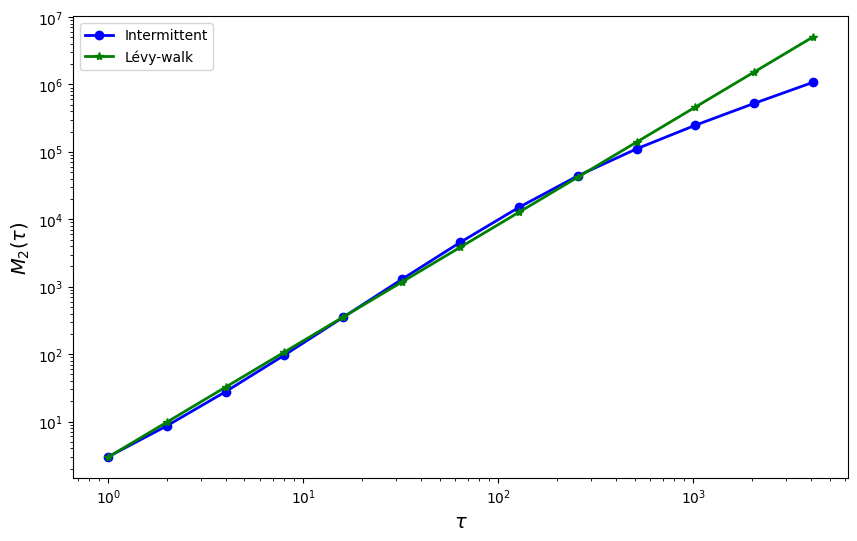

In [19]:
reg2 = LinearRegression().fit(np.log2(np.array(tau_list)).reshape(-1, 1),
                              np.log2(int_second_moment_list))
coef = 1.08*reg2.coef_[0]
intercept = 0.8*reg2.intercept_
lev_second_moment_list = []
for i in range(len(tau_list)):
    lev_second_moment_list.append(2**(intercept+coef*log_tau_list[i]))

plt.figure(figsize=(10, 6))
plt.plot(tau_list,int_second_moment_list,c = 'blue',marker = "o",alpha=1,
         label='Intermittent',linewidth = 2)
plt.plot(tau_list,lev_second_moment_list,c = 'g',marker = "*",alpha=1,
         label='Lévy-walk',linewidth = 2)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$ M_2(\tau) $',fontsize=14,fontweight = 'bold')
plt.xlabel(r'$\tau$',fontsize=14,fontweight = 'bold')
plt.legend()
#plt.savefig('INTvsLEVY_M2.pdf')
plt.show()

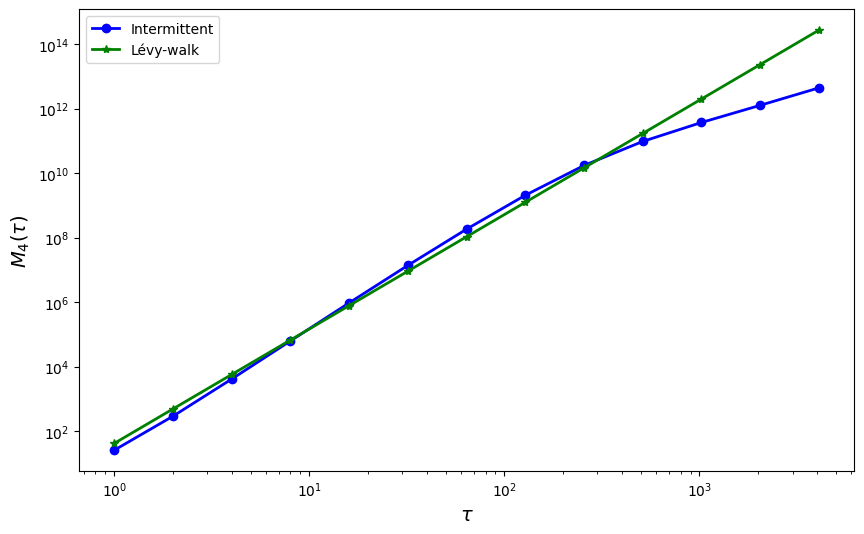

In [20]:
reg4 = LinearRegression().fit(np.log2(np.array(tau_list)).reshape(-1, 1),
                              np.log2(int_fourth_moment_list))
coef = 1.1*reg4.coef_[0]
intercept = 0.85*reg4.intercept_
lev_fourth_moment_list = []
for i in range(len(tau_list)):
    lev_fourth_moment_list.append(2**(intercept+coef*log_tau_list[i]))

plt.figure(figsize=(10, 6))
plt.plot(tau_list,int_fourth_moment_list,c = 'blue',marker = "o",
         alpha=1,label='Intermittent',linewidth = 2)
plt.plot(tau_list,lev_fourth_moment_list,c = 'green',marker = "*",
         alpha=1,label='Lévy-walk',linewidth = 2)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$ M_4(\tau) $',fontsize=14, fontweight ='bold')
plt.xlabel(r'$\tau$',fontsize=14, fontweight ='bold')
plt.legend()
#plt.savefig('INTM4.pdf')
plt.show()


# Intermittent and Leavy Fit

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from sklearn.neighbors import KernelDensity
import functools
import math
#import functions_eye_tracker_project as funcs
#import separation_algorithm as sepa
import seaborn as sns
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
import random


In [22]:
og_params =[]
est_params =[]
diff_params = []
est_diff_params =[]       
diff_diff_params=[]
diff_est_params=[]
r_square_list=[]
integration_factor = 80
g_tau = 1
g_v0 = 5
g_D = 1
g_lambda_B = 0.05
g_lambda_D = 0.005
N = 100000
N_iter = 1000
redim_max = 2
adj_r_square_int_lev = []
adj_r_square_int_int = []
lev_params_int = []
int_params_int = []
#tau_list = np.arange(1,30)
tau_list = np.power(1.44,np.arange(0,20)).astype(int)

#create grid with "tighter" parameters
#create 200 initial points at ranfrom from the "tighter" parameter grid
for itera in range(2):
    factor1 =  1
    factor2 =  1
    factor3 =  1
    factor4 =  1
    
    x_loc,y_loc = intermittent2(N*integration_factor,g_tau/integration_factor,g_v0*factor1,g_D*factor2,g_lambda_B*factor3,g_lambda_D*factor4)
    x_list = []
    y_list = []
    dx_list = []
    dy_list = []
    dx4 = []
    dy4 = []
    dx2 = []
    dy2 = []
    N_max = 1000
    for i in tau_list:
        x_list.append(x_loc[::i*integration_factor])
        y_list.append(y_loc[::i*integration_factor])
        dx_list.append(np.diff(x_loc[::i*integration_factor]))
        dy_list.append(np.diff(y_loc[::i*integration_factor]))

        dx4.append(np.mean(np.array(dx_list[-1])**4))
        dy4.append(np.mean(np.array(dy_list[-1])**4))
        dx2.append(np.mean(np.array(dx_list[-1])**2))
        dy2.append(np.mean(np.array(dy_list[-1])**2))
    dx4 = np.array(dx4)
    dy4 = np.array(dy4)
    dx4_log = np.log10(dx4)
    dy4_log = np.log10(dy4)
    dx2 = np.array(dx2)
    dy2 = np.array(dy2)
    dx2_log = np.log10(dx2)
    dy2_log = np.log10(dy2)
    g_emp_points_x = np.array(dx4_log)
    g_emp_points_y = np.array(dy4_log)

    #start initial parameter search grid
    grid_nodes = 20
    redim_power = redim_max**(2/grid_nodes)
    redim_vec = np.power(redim_power,np.arange(-grid_nodes*0.5,grid_nodes*0.5))
    gl_v_vec = g_v0 * redim_vec
    gl_d_vec = g_D * redim_vec
    gl_lambdaB_vec = g_lambda_B * redim_vec
    gl_lambdaD_vec = g_lambda_D * redim_vec
    param_grid = np.array(np.meshgrid(gl_v_vec,gl_d_vec,gl_lambdaB_vec,gl_lambdaD_vec)).T.reshape(-1,4)
    temp_adjus_r_int_sq_x = []
    temp_adjus_r_int_sq_x_diff = []
    temp_adjus_r_int_sq_y = []
    del_max_r_s = 0
    del_max_r_s_diff = 0
    print(itera)
    for ki in range(len(param_grid)):
        '''try:
            popt_x_diff, pcov_x = scipy.optimize.curve_fit(mom22_4_diff_log, np.array(tau_list), (np.array(dx4_log) - 2*np.array(dx2_log)),p0 = param_grid[ki] ,bounds=(np.min(param_grid)/10, [np.inf, np.inf, np.inf,np.inf]),maxfev=500000)
        except ValueError:
            print("could not find solution within bounds")'''      
        popt_x = param_grid[ki]
        popt_x_diff = param_grid[ki]
        #popt_y_diff, pcov_x = scipy.optimize.curve_fit(mom22_4_diff_log, np.array(tau_list), np.array(dy4_log) - 2*np.array(dy2_log),p0 = param_grid[ki],bounds=(np.min(param_grid)/10, [np.inf, np.inf, np.inf,np.inf]),maxfev=500000)
        g_int_fit_x_diff = mom22_4_diff_log(np.array(tau_list),popt_x_diff[0],popt_x_diff[1],popt_x_diff[2],popt_x_diff[3])
        g_int_fit_x = mom4_log(np.array(tau_list),popt_x[0],popt_x[1],popt_x[2],popt_x[3])
        #g_int_fit_y = mom22_4_diff_log(np.array(tau_list),popt_y_diff[0],popt_y_diff[1],popt_y_diff[2],popt_y_diff[3])
        temp_adjus_r_int_sq_x.append(adjusted_r_square(np.array(dx4_log) ,g_int_fit_x,4))
        temp_adjus_r_int_sq_x_diff.append(adjusted_r_square( np.array(dx4_log) - 2*np.array(dx2_log) ,g_int_fit_x_diff,4))
        if adjusted_r_square(np.array(dx4_log) ,g_int_fit_x,4) > del_max_r_s:
            del_max_r_s = adjusted_r_square(np.array(dx4_log) ,g_int_fit_x,4)
            best_popt_x = popt_x
        if adjusted_r_square( np.array(dx4_log) - 2*np.array(dx2_log) ,g_int_fit_x_diff,4) > del_max_r_s_diff:
            del_max_r_s_diff =  adjusted_r_square( np.array(dx4_log) - 2*np.array(dx2_log) ,g_int_fit_x_diff,4) 
            best_popt_x_diff = popt_x_diff
    print(itera)
    og_params.append([g_v0*factor1,g_D*factor2,g_lambda_B*factor3,g_lambda_D*factor4])
    est_params.append([best_popt_x[0],best_popt_x[1],best_popt_x[2],best_popt_x[3]])
    #est_diff_params.append([best_popt_x_diff[0],best_popt_x_diff[1],best_popt_x_diff[2],best_popt_x_diff[3]])

    #diff_diff_params.append( [(g_v0*factor1 - best_popt_x_diff[0]) / (g_v0*factor1) , (g_D*factor2-best_popt_x_diff[1])/(g_D*factor2),(g_lambda_B*factor3 - best_popt_x_diff[2])/(g_lambda_B*factor3),(g_lambda_D*factor4-best_popt_x_diff[3])/(g_lambda_D*factor4) ])
    diff_est_params.append([ (g_v0*factor1 - best_popt_x[0]) / (g_v0*factor1) , (g_D*factor2-best_popt_x[1])/(g_D*factor2),(g_lambda_B*factor3 - best_popt_x[2])/(g_lambda_B*factor3),(g_lambda_D*factor4-best_popt_x[3])/(g_lambda_D*factor4) ])
    #print(del_max_r_s,del_max_r_s_diff)
    #print(factor1,factor2,factor3,factor4)
    print(g_v0*factor1,g_D*factor2,g_lambda_B*factor3,g_lambda_D*factor4)
    #print(best_popt_x_diff)
    print(best_popt_x)
    #print(popt_y)
    #print(popt_y_diff)
    reg2 = LinearRegression().fit(np.log10(np.array(tau_list)).reshape(-1, 1), dx4_log)
    coef = reg2.coef_[0]
    intercept = reg2.intercept_
    lev_params_int.append([coef,intercept])
    g_lev_fit_x4  = coef*np.log10(np.array(tau_list)) + intercept
    g_int_fit_x4 = mom4_log(np.array(tau_list),best_popt_x[0],best_popt_x[1],best_popt_x[2],best_popt_x[3])
    reg2 = LinearRegression().fit(np.log10(np.array(tau_list)).reshape(-1, 1), dx2_log)
    coef = reg2.coef_[0]
    intercept = reg2.intercept_
    g_lev_fit_x2  = coef*np.log10(np.array(tau_list)) + intercept
    g_int_fit_x2 = mom2_log(np.array(tau_list),best_popt_x[0],best_popt_x[1],best_popt_x[2],best_popt_x[3])
    adj_r_square_int_lev.append(adjusted_r_square(dx4_log,g_lev_fit_x4,2))
    adj_r_square_int_int.append(adjusted_r_square(dx4_log,g_int_fit_x4,4))
    '''
    np.savetxt('x_intermittent.txt',x_loc[::i*integration_factor])
    np.savetxt('y_intermittent.txt',y_loc[::i*integration_factor])
    np.savetxt('dx2_log_intermittent.txt',dx2_log)
    np.savetxt('dx4_log_intermittent.txt',dx4_log)
    np.savetxt('dx4_int_true_lev_fit.txt',g_lev_fit_x4)
    np.savetxt('dx2_int_true_lev_fit.txt',g_lev_fit_x2)
    np.savetxt('dx4_int_true_int_fit.txt',g_int_fit_x4)
    np.savetxt('dx2_int_true_int_fit.txt',g_int_fit_x2)
    '''

0
0
5 1 0.05 0.005
[5.         0.93303299 0.05       0.00535887]
1
1
5 1 0.05 0.005
[4.66516496 1.14869835 0.05       0.00535887]


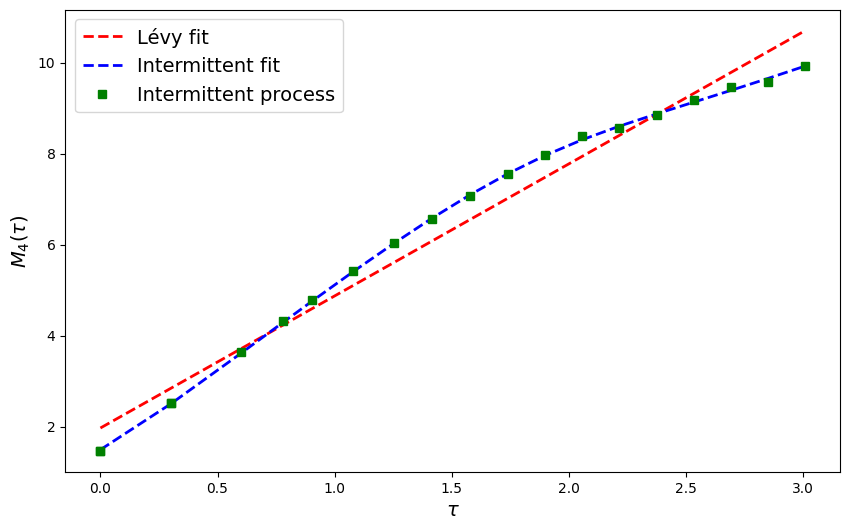

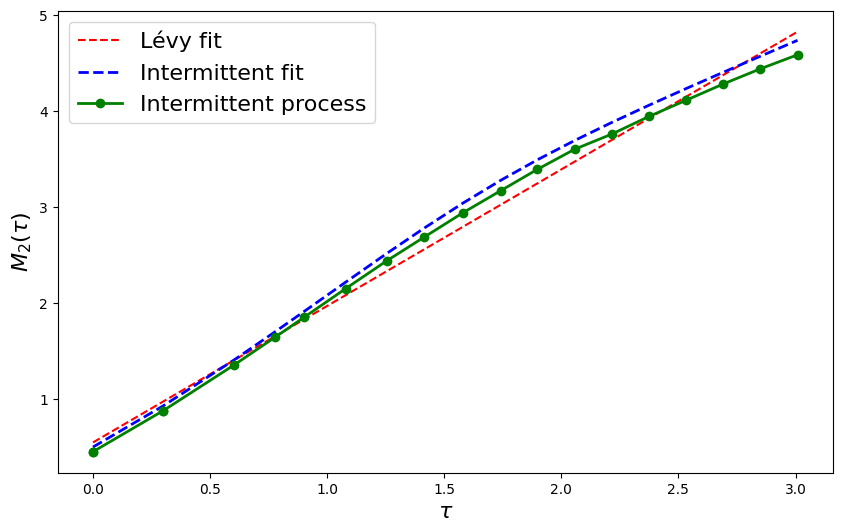

In [23]:
##Fourth moment
plt.figure(figsize=(10, 6))
tau_list = np.log10(np.power(1.44,np.arange(0,20)).astype(int))
plt.plot(tau_list,g_lev_fit_x4,'r--',label='Lévy fit',alpha=1,linewidth = 2)
plt.plot(tau_list,g_int_fit_x4,'b--',label='Intermittent fit',alpha=1,linewidth = 2)
plt.plot(tau_list,dx4_log,'s',c='g',label='Intermittent process',alpha=1,linewidth = 2)
plt.ylabel(r'$M_4(\tau)$',fontsize=14)
plt.xlabel(r'$\tau$',fontsize=14)
plt.legend(fontsize=14)
#plt.savefig("intermittent_fourth.png",dpi=300)
plt.show()

##Second moment
plt.figure(figsize=(10, 6))
tau_list = np.log10(np.power(1.44,np.arange(0,20)).astype(int))
plt.plot(tau_list,g_lev_fit_x2,'r--',label='Lévy fit',alpha=1)
plt.plot(tau_list,0.51*g_int_fit_x2,'b--',label='Intermittent fit',alpha=1,linewidth = 2)
plt.plot(tau_list,dx2_log,'go-',label='Intermittent process',alpha=1,linewidth = 2)
plt.ylabel(r'$M_2(\tau)$',fontsize=16)
plt.xlabel(r'$\tau$',fontsize=16)
plt.legend(fontsize=16)
#plt.savefig("intermittent_second.pdf")
plt.show()